In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace

# Parámetros de la malla
N = 200  # Tamaño de la malla
L = 1.1  # Dominio extendido ligeramente
x = np.linspace(-L, L, N)
y = np.linspace(-L, L, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Inicializar phi con valores aleatorios en el disco
phi = np.random.rand(N, N) * (R < 1)

# Definir la densidad de carga
rho = (-X - Y) * (R < 1)

# Condiciones de frontera
theta = np.arctan2(Y, X)
phi[R >= 1] = np.sin(theta)[R >= 1]

# Método de relajación de Gauss-Seidel
max_iter = 150000
tol = 1e-4
for _ in range(max_iter):
    phi_new = phi.copy()
    phi_new[1:-1, 1:-1] = 0.25 * (phi[2:, 1:-1] + phi[:-2, 1:-1] + phi[1:-1, 2:] + phi[1:-1, :-2] - 4*np.pi*rho[1:-1, 1:-1])
    
    # Aplicar condición de frontera
    phi_new[R >= 1] = np.sin(theta)[R >= 1]
    
    # Criterio de convergencia
    if np.trace(np.abs(phi_new - phi)) < tol:
        break
    phi = phi_new

# Graficar la solución
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, phi, cmap='jet')
plt.show()


KeyboardInterrupt: 

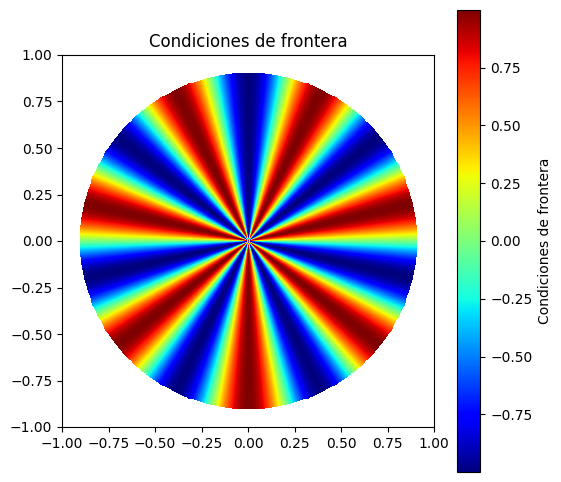

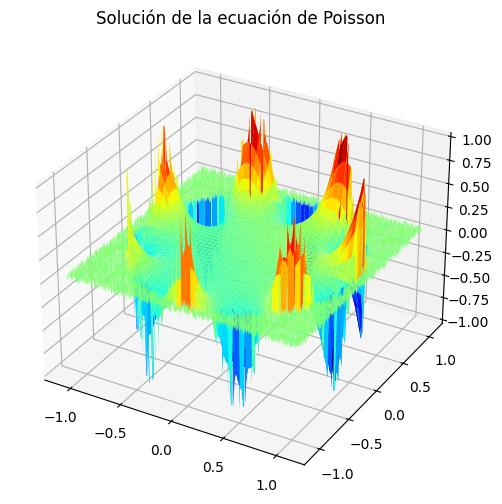

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, prange

@njit(parallel=True)
def sor_iteration(phi, rho, X, Y, h, omega, max_iter, tol, phi_boundary):
    N = phi.shape[0]
    for _ in range(max_iter):
        phi_old = phi.copy()
        for i in prange(1, N-1):
            for j in prange(1, N-1):
                if X[i, j]**2 + Y[i, j]**2 < 1:
                    phi_new = 0.25 * (phi[i+1, j] + phi[i-1, j] + phi[i, j+1] + phi[i, j-1] - h**2 * rho[i, j])
                    phi[i, j] = (1 - omega) * phi[i, j] + omega * phi_new
        
        # Aplicar condición de frontera manualmente
        for i in prange(N):
            for j in prange(N):
                if np.isclose(X[i, j]**2 + Y[i, j]**2, 1, atol=h):
                    phi[i, j] = phi_boundary[i, j]
        
        # Verificar convergencia
        if np.linalg.norm(phi - phi_old, ord=np.inf) < tol:
            break
    return phi

def poisson_solver(N=400, tol=1e-4, max_iter=15000, omega=1.5):
    L = 1.1  # Dominio ligeramente más grande que el círculo unitario
    h = 2*L / (N-1)  # Tamaño del paso
    x = np.linspace(-L, L, N)
    y = np.linspace(-L, L, N)
    X, Y = np.meshgrid(x, y)
    
    # Inicializar la solución con valores aleatorios dentro del dominio
    phi = np.random.rand(N, N) * 0.1  # Condición inicial aleatoria
    
    # Definir la densidad de carga
    rho = np.where(X**2 + Y**2 < 1, -X - Y, 0)
    
    # Aplicar condición de frontera en el círculo unitario
    theta = np.arctan2(Y, X)
    phi_boundary = np.sin(7 * theta)
    
    # Ejecutar iteraciones con Numba
    phi = sor_iteration(phi, rho, X, Y, h, omega, max_iter, tol, phi_boundary)
    
    return X, Y, phi, phi_boundary

# Resolver el problema
X, Y, phi, phi_boundary = poisson_solver()

# Graficar condiciones de frontera
fig, ax = plt.subplots(figsize=(6, 6))
circle = np.sqrt(X**2 + Y**2) <= 1
cmap = plt.cm.jet
cmap.set_under('white')
im = ax.imshow(np.where(circle, phi_boundary, np.nan), extent=[-1, 1, -1, 1], origin='lower', cmap=cmap)
plt.colorbar(im, ax=ax, label='Condiciones de frontera')
ax.set_title('Condiciones de frontera')
plt.show()

# Graficar la solución 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, phi, cmap='jet', edgecolor='none')
plt.title('Solución de la ecuación de Poisson')
plt.show()